<a href="https://colab.research.google.com/github/Natural-Language-Processing-SS24/task2/blob/main/Rezepte_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets scikit-learn
!pip install optuna
!pip install optuna-integration
!pip install torch
!pip install python-docx
!pip install accelerate -U
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.2 MB/s eta

## Bibliotheken importieren

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast
from google.colab import files
from sklearn.model_selection import train_test_split
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    Trainer, TrainingArguments
)
from datasets import Dataset, DatasetDict
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import gradio as gr
import torch

## Dateien hochladen und laden

In [3]:
# Dateien hochladen
uploaded = files.upload()

training_data_path = 'Recipes_Training.csv'
test_data_path = 'Recipes_Test.csv'

# Laden der Datensätze
training_df = pd.read_csv(training_data_path, delimiter=';')
test_df = pd.read_csv(test_data_path, delimiter=';')

Saving Recipes_Test.csv to Recipes_Test.csv
Saving Recipes_Training.csv to Recipes_Training.csv


## Explorative Datenanalyse

### Daten anzeigen

In [4]:
def display_dataframe_info(df, df_name):
    print(f"\nInformationen zum {df_name} DataFrame:")
    print(df.info())
    print(f"\nErste Zeilen des {df_name} DataFrame:")
    print(df.head())
    print("\n")

# Informationen und erste Zeilen der DataFrames anzeigen
display_dataframe_info(training_df, "Trainings")
display_dataframe_info(test_df, "Test")


Informationen zum Trainings DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           8000 non-null   int64 
 1   cuisine      8000 non-null   object
 2   ingredients  8000 non-null   object
dtypes: int64(1), object(2)
memory usage: 187.6+ KB
None

Erste Zeilen des Trainings DataFrame:
      id      cuisine                                        ingredients
0  25693  southern_us  ['plain flour', 'ground pepper', 'salt', 'toma...
1  22213       indian        ['water', 'vegetable oil', 'wheat', 'salt']
2  13162       indian  ['black pepper', 'shallots', 'cornflour', 'cay...
3   3735      italian  ['sugar', 'pistachio nuts', 'white almond bark...
4  16903      mexican  ['olive oil', 'purple onion', 'fresh pineapple...



Informationen zum Test DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data

### Verteilung der Küchen

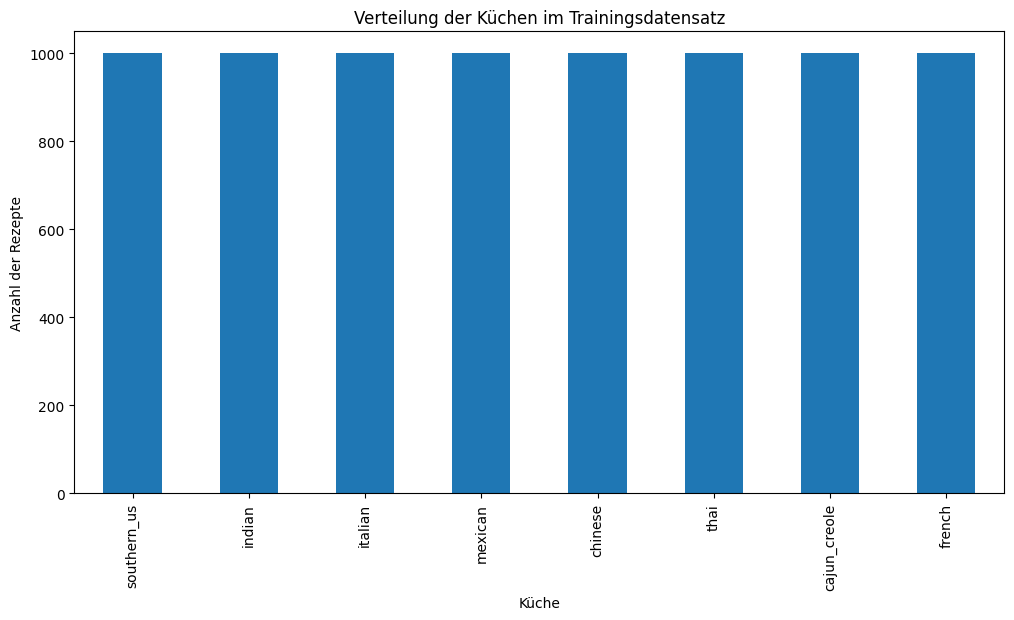

In [5]:
cuisine_counts = training_df['cuisine'].value_counts()
plt.figure(figsize=(12, 6))
cuisine_counts.plot(kind='bar')
plt.title('Verteilung der Küchen im Trainingsdatensatz')
plt.xlabel('Küche')
plt.ylabel('Anzahl der Rezepte')
plt.show()

### Häufigste Zutaten analysieren

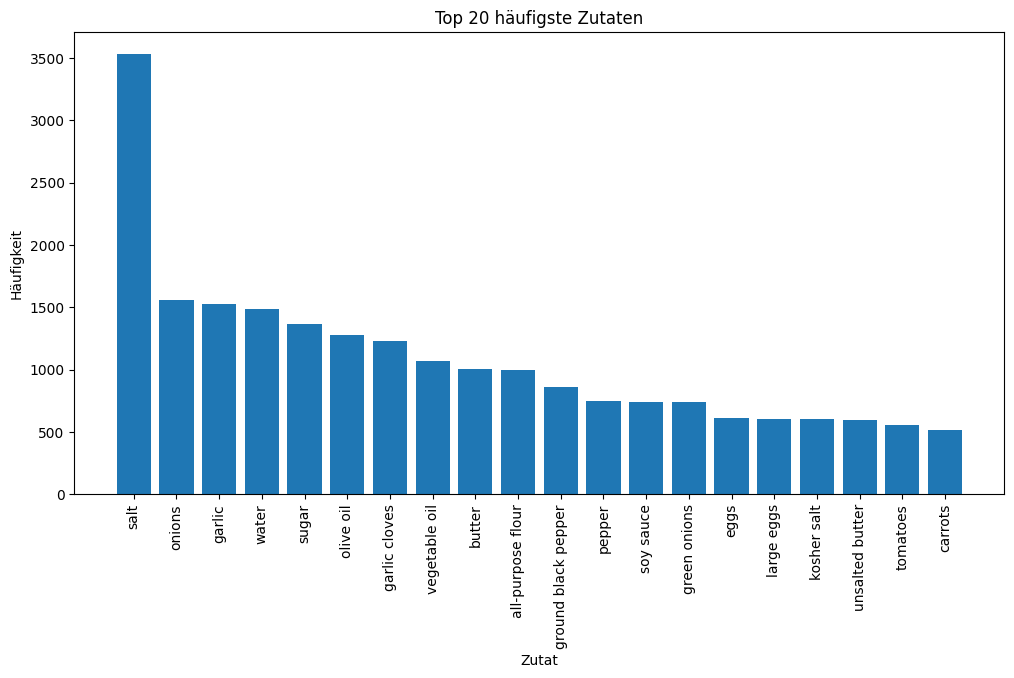

In [6]:
# Häufigste Zutaten
all_ingredients = []
for ingredients_list in training_df['ingredients']:
    ingredients = ast.literal_eval(ingredients_list)
    all_ingredients.extend(ingredients)

ingredient_counts = Counter(all_ingredients)

# Top 20 häufigste Zutaten
top_ingredients = ingredient_counts.most_common(20)
ingredients, counts = zip(*top_ingredients)
plt.figure(figsize=(12, 6))
plt.bar(ingredients, counts)
plt.title('Top 20 häufigste Zutaten')
plt.xlabel('Zutat')
plt.ylabel('Häufigkeit')
plt.xticks(rotation=90)
plt.show()

### Top-Zutaten für jede Küche

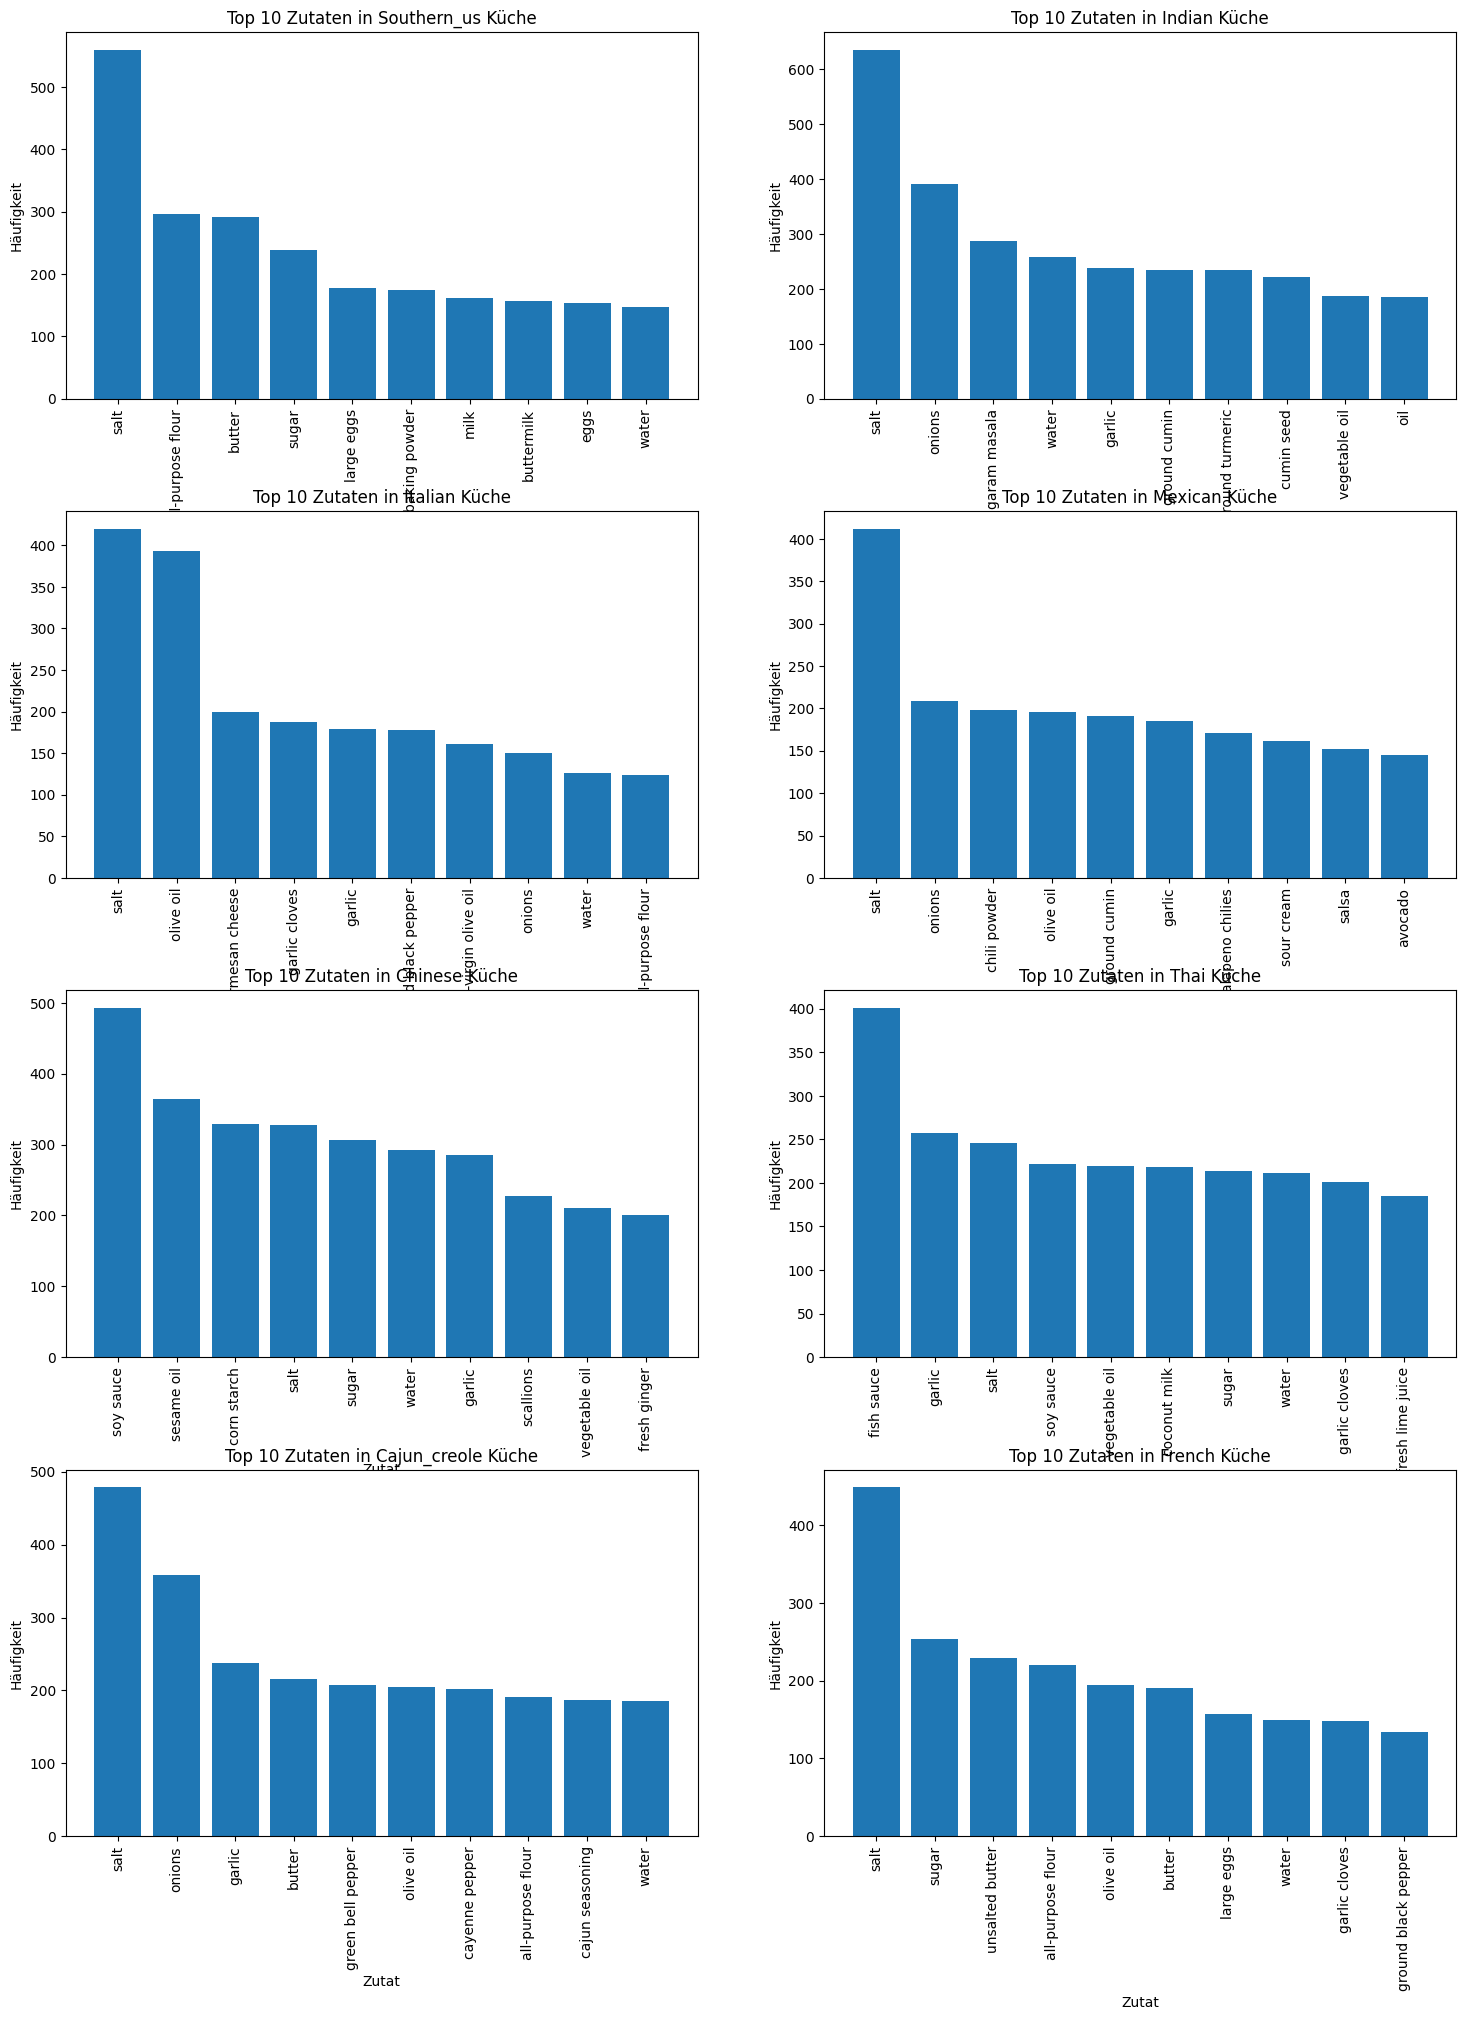

In [7]:
# Funktion, um die Top-Zutaten für jede Küche zu erhalten
def get_top_ingredients_by_cuisine(cuisine):
    cuisine_data = training_df[training_df['cuisine'] == cuisine]
    all_ingredients = []
    for ingredients_list in cuisine_data['ingredients']:
        ingredients = ast.literal_eval(ingredients_list)
        all_ingredients.extend(ingredients)
    ingredient_counts = Counter(all_ingredients)
    return ingredient_counts.most_common(10)

# Top-Zutaten für jede Küche
cuisines = training_df['cuisine'].unique()
top_ingredients_by_cuisine = {cuisine: get_top_ingredients_by_cuisine(cuisine) for cuisine in cuisines}

# Top-Zutaten für jede Küche plotten
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
fig.tight_layout(pad=6.0)

for ax, (cuisine, top_ingredients) in zip(axes.flatten(), top_ingredients_by_cuisine.items()):
    ingredients, counts = zip(*top_ingredients)
    ax.bar(ingredients, counts)
    ax.set_title(f'Top 10 Zutaten in {cuisine.capitalize()} Küche')
    ax.set_xlabel('Zutat')
    ax.set_ylabel('Häufigkeit')
    ax.tick_params(axis='x', rotation=90)

plt.show()

## Datenvorbereitung für Modell-Training

### Trainings- und Validierungsdaten splitten

In [8]:
# Trainings- und Validierungsdaten splitten
train_df, val_df = train_test_split(training_df, test_size=0.2, stratify=training_df['cuisine'], random_state=42)

# Datensätze in Hugging Face Dataset-Format umwandeln
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
datasets = DatasetDict({"train": train_dataset, "val": val_dataset})

# Maximale Länge für Padding und Trunkierung
max_length = 10

# Label-Konvertierung erstellen
label2id = {label: i for i, label in enumerate(training_df['cuisine'].unique())}
id2label = {i: label for label, i in label2id.items()}

### Text und Labels vorbereiten

In [9]:
# Text und Labels vorbereiten
def preprocess_function(examples):
    inputs = tokenizer(examples['ingredients'], padding='max_length', truncation=True, max_length=max_length)
    inputs['labels'] = [label2id[label] for label in examples['cuisine']]
    return inputs

## Funktion zur Modell-Trainierung

In [13]:
# Funktion zur Modell-Trainierung
def train_model(model_name, model_class, tokenizer_class, num_labels, num_epochs=1):
    global tokenizer
    tokenizer = tokenizer_class.from_pretrained(model_name)

    tokenized_datasets = datasets.map(preprocess_function, batched=True)

    model = model_class.from_pretrained(model_name, num_labels=num_labels)

    training_args = TrainingArguments(
        output_dir='./results',
        eval_strategy="epoch",
        logging_strategy="steps",
        logging_steps=10,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["val"],
    )

    trainer.train()

    # Evaluierung
    eval_results = trainer.evaluate()
    print(f"Evaluation results for {model_name}:")
    print(eval_results)

    # Vorhersagen und Berechnung der Metriken
    val_predictions = trainer.predict(tokenized_datasets["val"]).predictions
    val_predictions = np.argmax(val_predictions, axis=1)
    val_labels = tokenized_datasets["val"]['labels']

    # Klassifikationsbericht
    print(f"Classification Report for {model_name}:")
    print(classification_report(val_labels, val_predictions, target_names=list(label2id.keys())))

    # Konfusionsmatrix
    cm = confusion_matrix(val_labels, val_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(label2id.keys()), yticklabels=list(label2id.keys()), cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    return model

## Modelle trainieren

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.826000,1.790462


Evaluation results for distilbert-base-uncased:
{'eval_loss': 1.7904621362686157, 'eval_runtime': 0.7552, 'eval_samples_per_second': 2118.686, 'eval_steps_per_second': 132.418, 'epoch': 1.0}
Classification Report for distilbert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.25      0.37      0.30       200
      indian       0.40      0.29      0.34       200
     italian       0.35      0.52      0.42       200
     mexican       0.41      0.26      0.32       200
     chinese       0.45      0.41      0.43       200
        thai       0.34      0.46      0.39       200
cajun_creole       0.50      0.25      0.33       200
      french       0.29      0.28      0.28       200

    accuracy                           0.35      1600
   macro avg       0.38      0.35      0.35      1600
weighted avg       0.38      0.35      0.35      1600



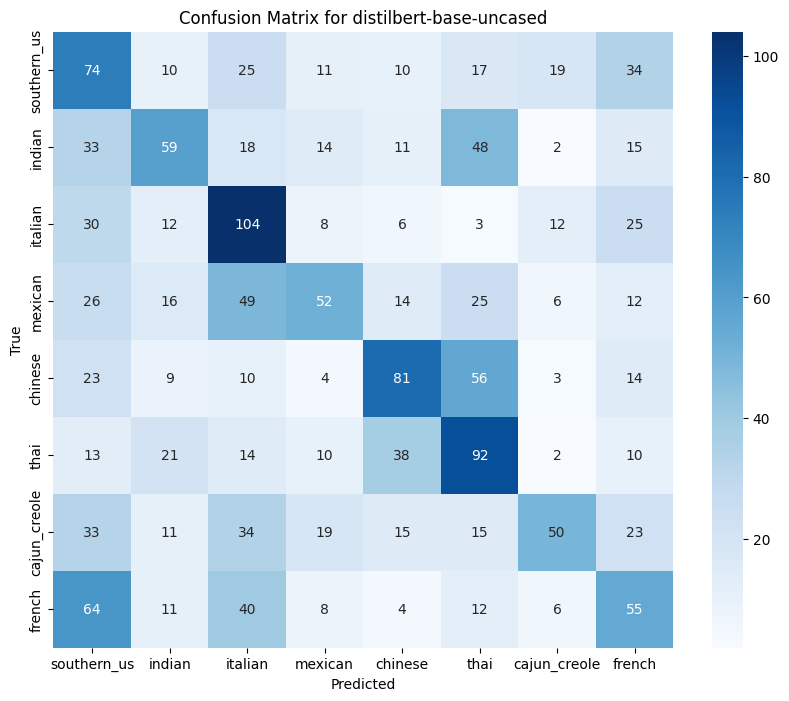

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.763400,1.762513


Evaluation results for bert-base-uncased:
{'eval_loss': 1.7625125646591187, 'eval_runtime': 1.3729, 'eval_samples_per_second': 1165.409, 'eval_steps_per_second': 72.838, 'epoch': 1.0}
Classification Report for bert-base-uncased:
              precision    recall  f1-score   support

 southern_us       0.25      0.35      0.29       200
      indian       0.39      0.34      0.37       200
     italian       0.41      0.35      0.38       200
     mexican       0.33      0.40      0.36       200
     chinese       0.53      0.41      0.46       200
        thai       0.36      0.42      0.39       200
cajun_creole       0.42      0.26      0.32       200
      french       0.28      0.30      0.29       200

    accuracy                           0.35      1600
   macro avg       0.37      0.35      0.36      1600
weighted avg       0.37      0.35      0.36      1600



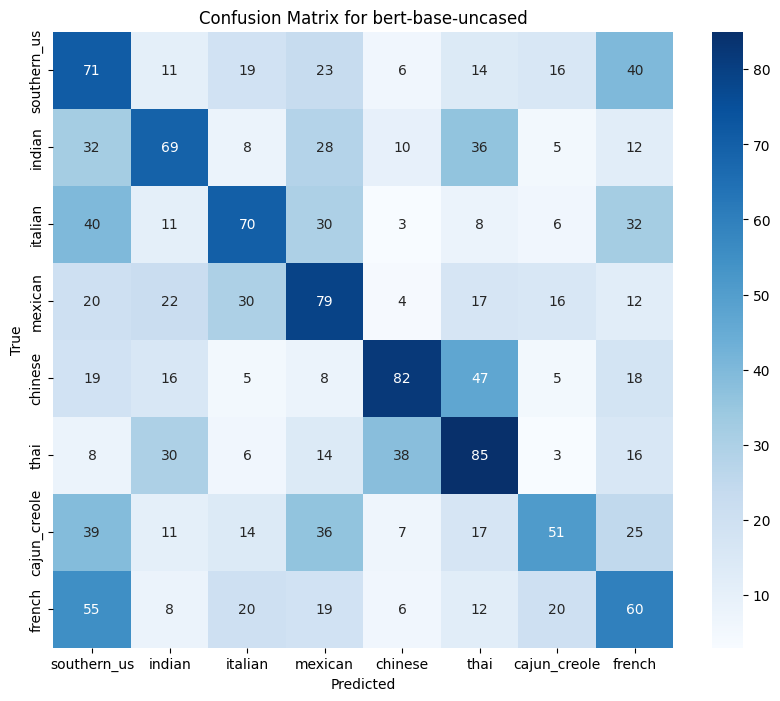

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.798300,1.726445


Evaluation results for bert-large-uncased:
{'eval_loss': 1.7264448404312134, 'eval_runtime': 4.3367, 'eval_samples_per_second': 368.948, 'eval_steps_per_second': 23.059, 'epoch': 1.0}
Classification Report for bert-large-uncased:
              precision    recall  f1-score   support

 southern_us       0.24      0.42      0.30       200
      indian       0.50      0.36      0.42       200
     italian       0.36      0.47      0.41       200
     mexican       0.36      0.34      0.35       200
     chinese       0.58      0.45      0.50       200
        thai       0.43      0.37      0.40       200
cajun_creole       0.33      0.35      0.34       200
      french       0.29      0.16      0.21       200

    accuracy                           0.36      1600
   macro avg       0.39      0.36      0.37      1600
weighted avg       0.39      0.36      0.37      1600



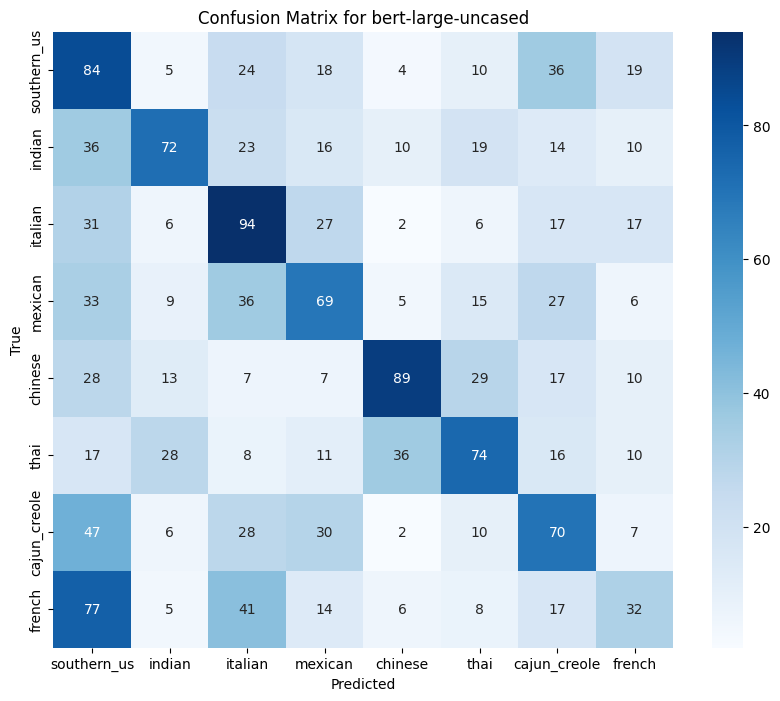

In [14]:
# Überprüfen, ob GPU verfügbar ist
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Anzahl der Klassen
num_labels = len(training_df['cuisine'].unique())

# Modelle trainieren
distilbert_model = train_model('distilbert-base-uncased', DistilBertForSequenceClassification, DistilBertTokenizer, num_labels).to(device)
bert_base_model = train_model('bert-base-uncased', BertForSequenceClassification, BertTokenizer, num_labels).to(device)
bert_large_model = train_model('bert-large-uncased', BertForSequenceClassification, BertTokenizer, num_labels).to(device)

## Gradio-Oberfläche erstellen

In [16]:
# Funktion zur Vorhersage mit allen Modellen
def classify_recipe(recipe):
    print(f"Rezept klassifizieren: {recipe}")
    inputs = tokenizer(recipe, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)

    # Entfernen von 'token_type_ids' für DistilBERT
    if 'token_type_ids' in inputs:
        del inputs['token_type_ids']

    predictions = {}

    # DistilBERT
    with torch.no_grad():
        outputs = distilbert_model(**inputs)
    distilbert_prediction = torch.argmax(outputs.logits, dim=1).item()
    predictions['DistilBERT'] = id2label[distilbert_prediction]

    # BERT Base
    with torch.no_grad():
        outputs = bert_base_model(**inputs)
    bert_base_prediction = torch.argmax(outputs.logits, dim=1).item()
    predictions['BERT Base'] = id2label[bert_base_prediction]

    # BERT Large
    with torch.no_grad():
        outputs = bert_large_model(**inputs)
    bert_large_prediction = torch.argmax(outputs.logits, dim=1).item()
    predictions['BERT Large'] = id2label[bert_large_prediction]

    return predictions

def get_recipe(index):
    try:
        print(f"Rezept für Index abrufen: {index}")
        index = int(index.split(":")[0])
        recipe = training_df.iloc[index]['ingredients']
        cuisine = training_df.iloc[index]['cuisine']
        print(f"Rezept: {recipe}, Küche: {cuisine}")
        return recipe, cuisine
    except Exception as e:
        print(f"Fehler bei get_recipe: {e}")
        return "", ""

def get_results_for_recipe(index):
    try:
        print(f"Ausgewählter Index: {index}")
        recipe, cuisine = get_recipe(index)
        if recipe == "":
            return {"Fehler": "Ungültiger Index oder Rezept nicht gefunden"}, ""
        results = classify_recipe(recipe)
        results['Tatsächliche Küche'] = cuisine
        return results, recipe
    except Exception as e:
        print(f"Fehler bei get_results_for_recipe: {e}")
        return {"Fehler": f"Ein Fehler ist aufgetreten: {e}"}, ""

# Gradio-Komponente für den Rezept-Picker
recipe_picker = gr.Dropdown(
    choices=[f"{i}: {recipe[:50]}" for i, recipe in enumerate(training_df['ingredients'])],
    label="Rezept auswählen",
    interactive=True
)

# Gradio-Oberfläche erstellen
interface = gr.Interface(
    fn=get_results_for_recipe,
    inputs=recipe_picker,
    outputs=[gr.Json(label="Vorhersagen"), gr.Textbox(label="Ausgewähltes Rezept")],
    title="Rezeptklassifizierung"
)

# Starten der Gradio-Oberfläche
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://78e87f5a8c4247f0fe.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
